In [1]:
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import PIL.Image as Image
import tensorflow as tf

from google.protobuf import text_format
from modeling import trainer
from modeling.utils import visualization
from modeling.utils.box_ops import py_iou
from protos import pipeline_pb2

%matplotlib inline

image_dir = "vg-gt-cap/images"
model_dir = "logs/base_phr_ite_seq/"

for gpu in tf.config.experimental.list_physical_devices('GPU'):
  tf.config.experimental.set_memory_growth(gpu, True)

with tf.io.gfile.GFile(os.path.join(model_dir, "pipeline.pbtxt"), 'r') as fp: 
  pipeline_proto = text_format.Merge(fp.read(), pipeline_pb2.Pipeline())
batch_generator = trainer.predict(pipeline_proto, model_dir)


def get_examples():
  """Returns a generator that yields a single example each time. """
  while True:
    try:
      i = next(example_id_generator)
    except Exception as ex:
      example = next(batch_generator)
      example_id_generator = (i for i in range(len(example['id'])))
      i = next(example_id_generator)
    
    image_id = example['id'][i]
    num_relations = example['common_sense/prediction/num_relations'][i]
    
    (predicate_classes, subject_boxes, subject_classes, object_boxes, object_classes
    ) = (example['common_sense/prediction/relation_class'][i][:num_relations],
         example['common_sense/prediction/subject_box'][i][:num_relations],
         example['common_sense/prediction/subject_class'][i][:num_relations],
         example['common_sense/prediction/object_box'][i][:num_relations],
         example['common_sense/prediction/object_class'][i][:num_relations])  
    yield (image_id, predicate_classes, subject_boxes, subject_classes, object_boxes, object_classes)
  

example_generator = get_examples()


def insert_entity(entity_boxes, entity_names, box, name):
  """Insert entities."""
  seq_id = 0
  for i in range(len(entity_names)):
    if name == entity_names[i].split(':')[0] and py_iou(box, entity_boxes[i]) > 0.5:
      return i
    if name == entity_names[i].split(':')[0]:
      seq_id += 1
  entity_names.append(name if seq_id == 0 else name + ':%i' % seq_id)
  entity_boxes.append(box)
  return len(entity_names) - 1


Processing 713080.
Processing 2416123.
Processing 2350743.
Processing 2390992.
Processing 2358366.


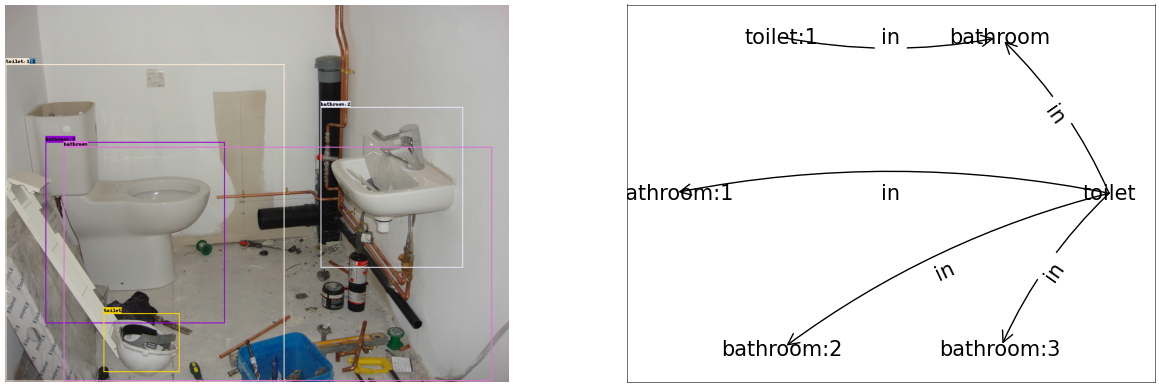

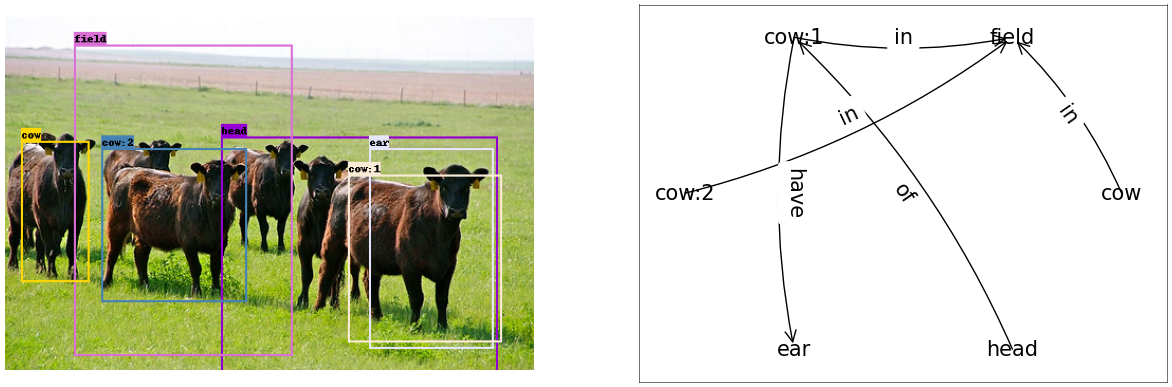

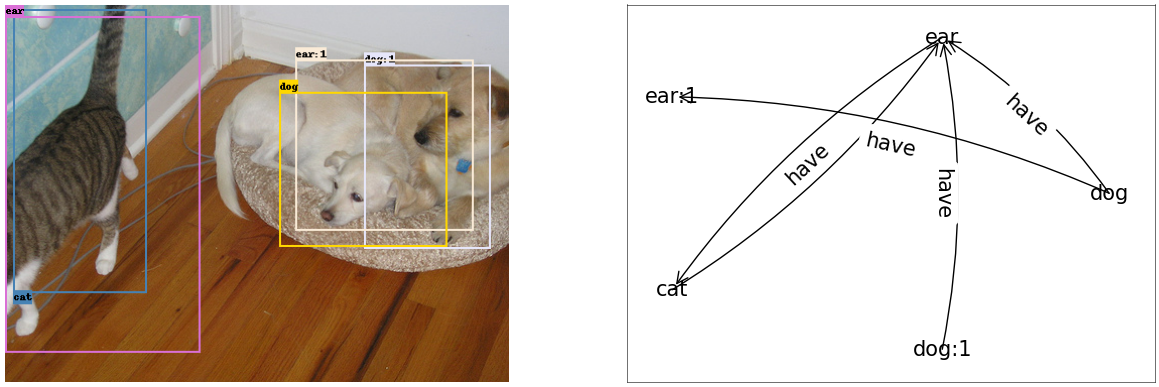

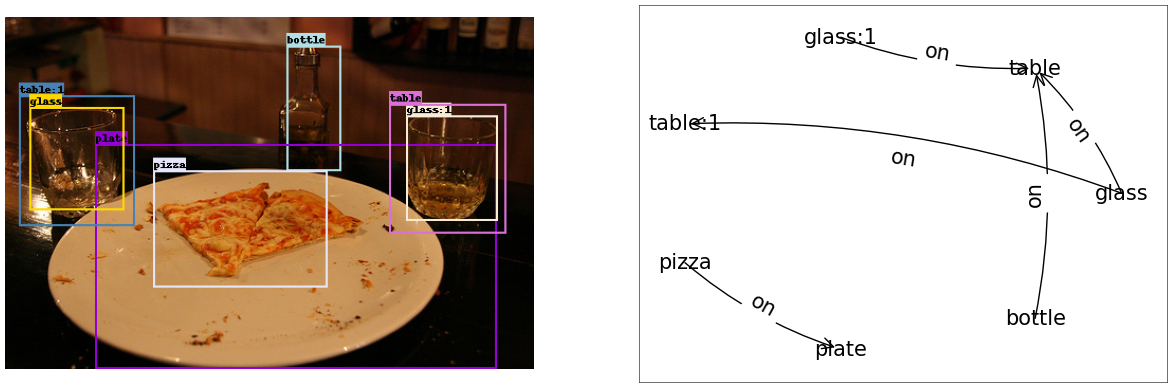

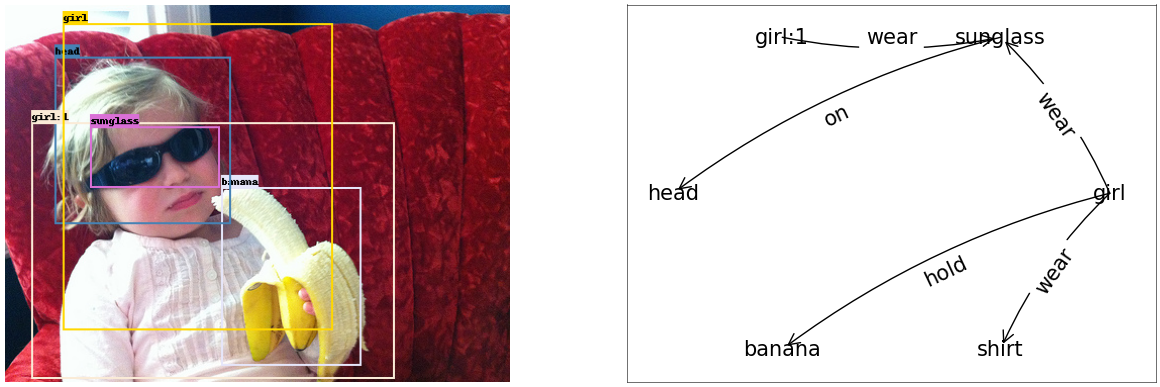

In [4]:

for _ in range(5):
  (image_id, predicate_classes, 
   subject_boxes, subject_classes, object_boxes, object_classes) = next(example_generator)
  print('Processing %i.' % image_id)
    
  plt.figure(figsize=(30, 10), dpi=50)

  # Load original image.
  image = np.array(Image.open(os.path.join(image_dir, '%i.jpg' % image_id)))

  entity_names = []  # Name with sequenceId, e.g., horse, cat, person:0, person:1, person:2.
  entity_boxes = []

  g = nx.DiGraph()
  for index, (sub, sub_box, pred, obj, obj_box) in enumerate(
      zip(subject_classes, subject_boxes, predicate_classes, object_classes, object_boxes)):
    if index >= 5: break
    sub_id = insert_entity(entity_boxes, entity_names, sub_box, sub.decode('ascii'))
    obj_id = insert_entity(entity_boxes, entity_names, obj_box, obj.decode('ascii'))
    
    g.add_edge(entity_names[sub_id], entity_names[obj_id], label=pred.decode('ascii'), weight=0)

  # Show image with detected entities.
  ax = plt.subplot(1, 2, 1)
  image_with_detections = visualization.draw_bounding_box_py_func_fn(
      image, len(entity_names), entity_boxes, entity_names, None, 2)
  plt.imshow(image)
  plt.axis('off')

  # Show predicted scene graph.
  ax = plt.subplot(1, 2, 2)
  pos = nx.shell_layout(g)
  nx.draw_networkx_nodes(g, pos, node_size=0, node_shape='o', node_color='#1f78b4')
  nx.draw_networkx_labels(g, pos, font_size=30, font_family='sans-serif')
  nx.draw_networkx_edges(g, pos, arrowsize=40, width=2, draw_networkx_edges=True, 
                         arrowstyle='->', connectionstyle='arc3, rad=0.1')
  nx.draw_networkx_edge_labels(
      g, pos, font_size=30, edge_labels=dict([((u, v), d['label']) for u, v, d in g.edges(data=True)]))